# Mask R-CNN (Predict-n-Save)


## Your Configurations here

In [3]:
# YOUR CONFIGURATIONS
IMAGE_PATH = 'C:/Users/ASUS/Desktop/test'
WEIGHT_FILE = 'mask_rcnn_coco.h5'
OUTPUT_JSON_FILE_NAME = "instances_train.json"
save_predicted_images = False

## Imports and Directory Setup

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import datetime
import json
from pycococreatortools import pycococreatortools

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

sys.path.append(os.path.join(ROOT_DIR, "configs"))  # To find local version
# Import your config here
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, WEIGHT_FILE)
# directory to save predictions in json file
OUTPUT_DIR = os.path.join(ROOT_DIR, "output")
# directory to save predicted image
OUTPUT_IMG_DIR = os.path.join(OUTPUT_DIR, "predicted images")
# directory to save bbox in yolo format
BBOX_DIR = os.path.join(OUTPUT_DIR, "yolo bbox")

# directories are created if the folder does not exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)   
if not os.path.exists(BBOX_DIR):
    os.makedirs(BBOX_DIR)
if not os.path.exists(OUTPUT_IMG_DIR):
    os.makedirs(OUTPUT_IMG_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, WEIGHT_FILE)
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\asus\appdata\

... done downloading pretrained model!


## Configurations


In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## JSON Dataset Components



In [7]:
INFO = {
    "description": "Example Dataset",
    "url": "https://example.com",
    "version": "1.x.x",
    "year": 2018,
    "contributor": "example",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://license.com"
    }
]


with open('categories.json', 'r') as json_file:
    CATEGORIES = json.load(json_file)
    
coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}

## Classes in YOLO format

In [8]:
if os.path.exists('{}/{}'.format(BBOX_DIR, "classes.txt")):
    os.remove('{}/{}'.format(BBOX_DIR, "classes.txt"))
    
class_names = ['BG']
f = open("{}/classes.txt".format(BBOX_DIR), "w+")
f.write("BG\n")
for category in CATEGORIES:
    f.write("{}\n".format(category['name']))
    class_names.append(category['name'])
    
f.close()

#clearing all bounding boxes txt
bbox_files = next(os.walk(BBOX_DIR))[2]
for bbox_file in bbox_files:
    if bbox_file != 'classes.txt':
        os.remove('{}/{}'.format(BBOX_DIR, bbox_file))

## Run Object Detection

Processing 1 images
image                    shape: (448, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


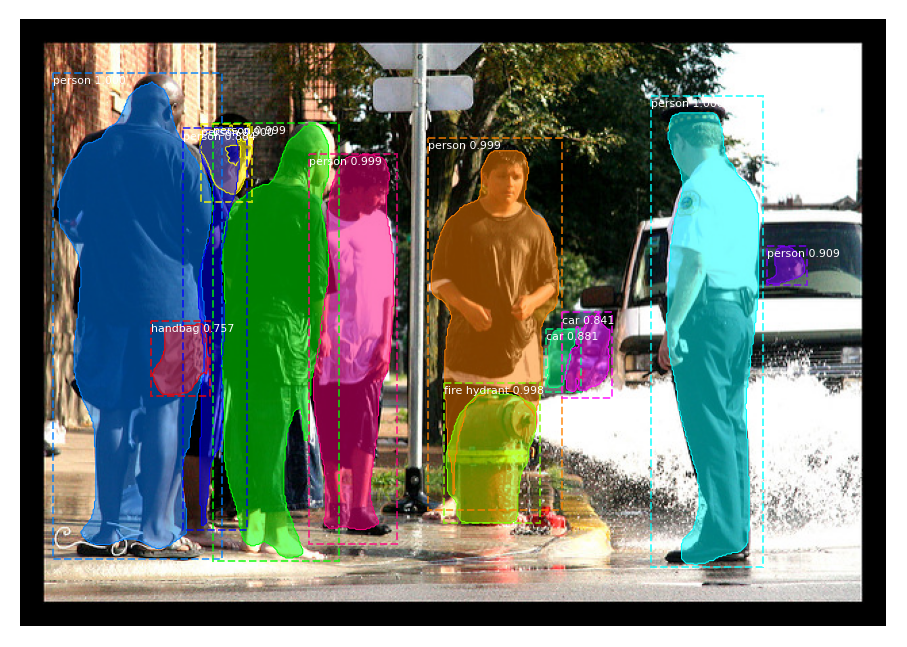

Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


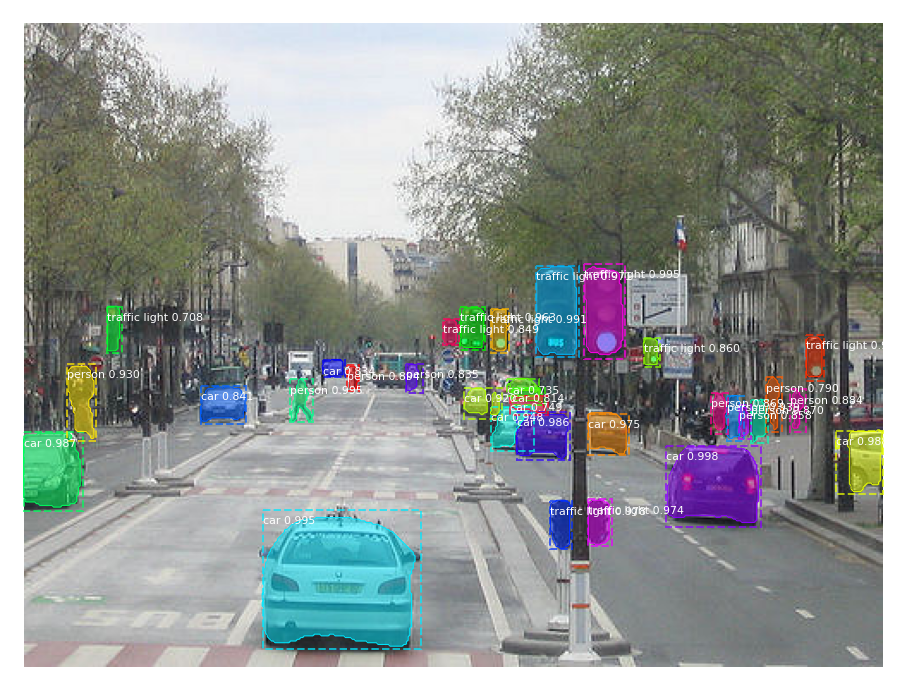

Processing 1 images
image                    shape: (428, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


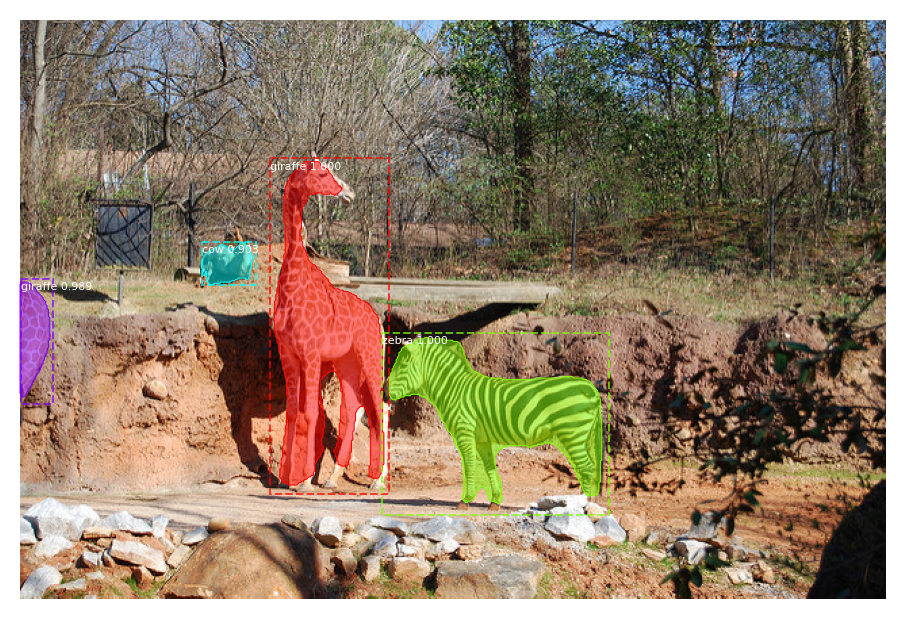

Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


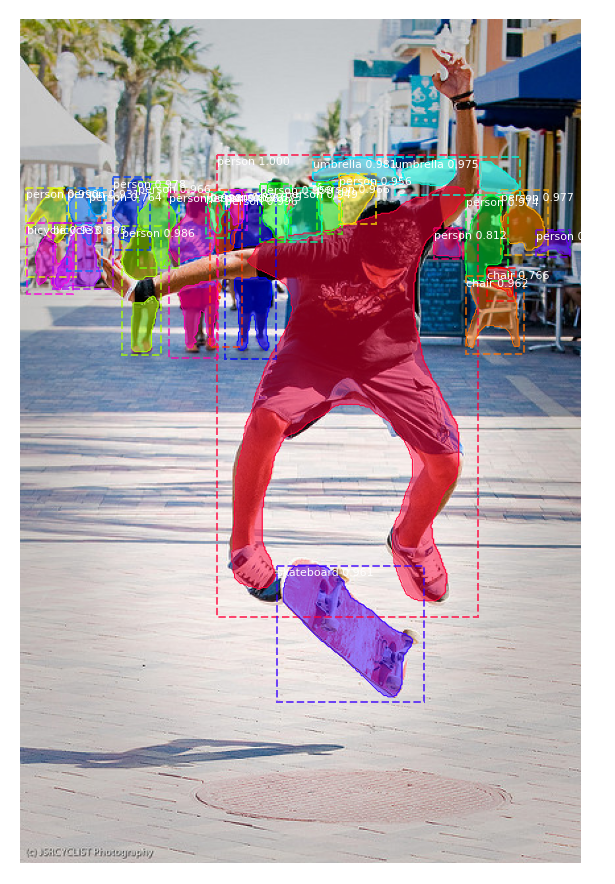

Processing 1 images
image                    shape: (415, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


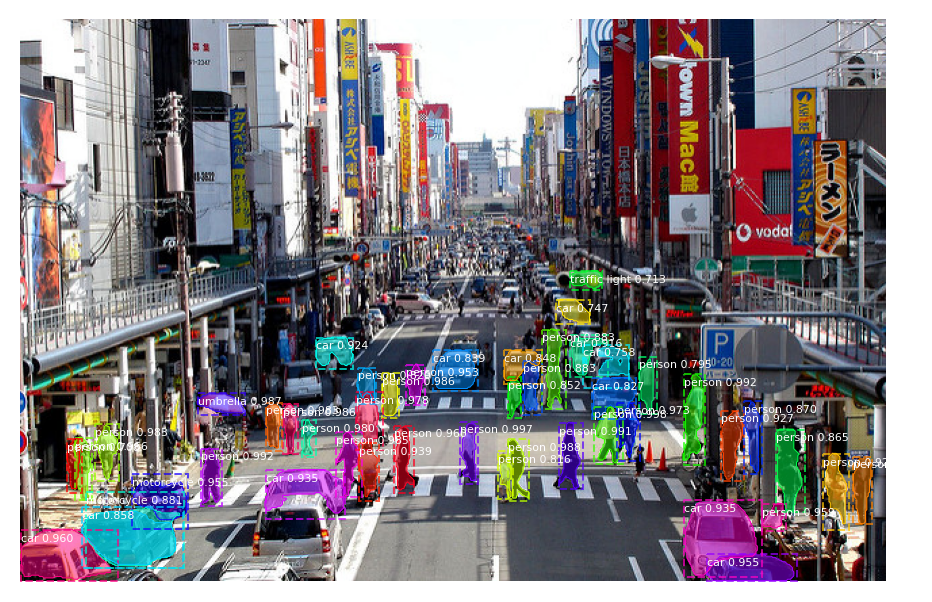

Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


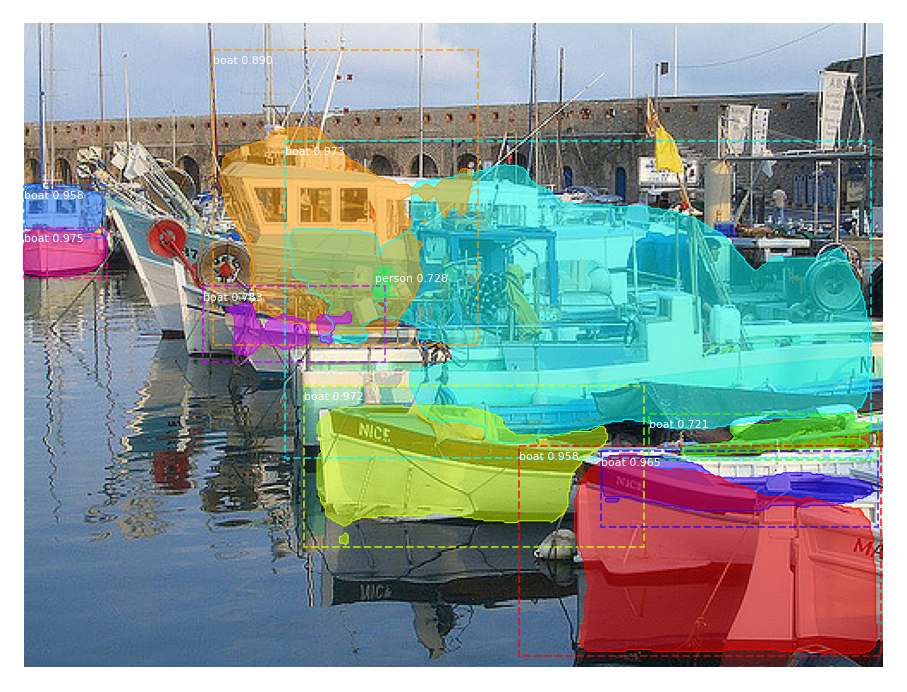

In [9]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_PATH))[2]

image_id = 0
segmentation_id = 0
  
for file_name in file_names:
    new_file_name = file_name.replace(".jpg","")
    new_file_name = new_file_name.replace(".png","")
    new_file_name = new_file_name.replace(".jpeg","")
    f = open("{}/{}.txt".format(BBOX_DIR, new_file_name), "w+")
    
    image = skimage.io.imread(os.path.join(IMAGE_PATH, file_name)) # read image file
    image_dimension = image.shape[::-1] # return (3, image width, image height) 3 because of rgb
    
    # image info is obtained through create_image_info
    # image_dimension[1:3] gives only width and height of the image
    image_info = pycococreatortools.create_image_info(
                image_id, file_name, image_dimension[1:3])
    coco_output["images"].append(image_info)

    # if image has rgba
    if image.shape[2] == 4:
        # remove alpha value to have rgb
        new_image = np.delete(image, 3, axis=2)
        results = model.detect([new_image], verbose=1)
    # if image has rgb
    else:
        # Run detection
        results = model.detect([image], verbose=1)  
        
    r = results[0]
      
    masks = np.array(r['masks'])
    segmentations = np.transpose(masks,(2, 0, 1))
    
    idx = 0
    for segmentation in segmentations:
        category_info = {'id': int(r['class_ids'][idx]), 'is_crowd': False}
        # annotation info is obtained through create_annotation_info
        annotation_info = pycococreatortools.create_annotation_info(
                                segmentation_id, image_id, category_info, segmentation, 
                                image_dimension[1:3], tolerance = 2, bounding_box=r['rois'][idx])
        
        if annotation_info is not None:
            # r['rois'] returns the bounding boxes corrdinates
            x1 = r['rois'][idx][1]
            y1 = r['rois'][idx][0]
            x2 = r['rois'][idx][3]
            y2 = r['rois'][idx][2]
            delta_x = abs(x2-x1)
            delta_y = abs(y2-y1)

            #(delta_x/width)/2+x1/width  (delta_y/height)/2+y1/height
            #(x1+x2)/(2*width)   (y1+y2)/(2*height)
            f.write("{} {} {} {} {}\n".format(int(r['class_ids'][idx]), 
                                              (x1+x2)/(2*image_dimension[1]), 
                                              (y1+y2)/(2*image_dimension[2]), 
                                              delta_x/image_dimension[1],
                                              delta_y/image_dimension[2]))
            coco_output["annotations"].append(annotation_info)
        idx += 1
        segmentation_id += 1
        
    f.close()
    image_id = image_id + 1

    if save_predicted_images:
        # Visualize results
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], save_path=OUTPUT_DIR+'/predicted images/'+'{}.png'.format(new_file_name))
    else:
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])



## Create and save Predictions

In [10]:
if os.path.exists('{}/{}'.format(OUTPUT_DIR, OUTPUT_JSON_FILE_NAME)):
    print("removing file")
    os.remove('{}/{}'.format(OUTPUT_DIR, OUTPUT_JSON_FILE_NAME))

print("creating json files...")
with open('{}/{}'.format(OUTPUT_DIR, OUTPUT_JSON_FILE_NAME), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)
print("{} created".format(OUTPUT_JSON_FILE_NAME))


creating json files...
instances_train.json created
